To be used after creating 
- the {target}_CLEAN_profile_robust{robust}.txt file with the "intensity_profile_CLEAN.ipynb" notebook
- the {target}_continuum_radii_frank_fit.txt file with the "intensity_profile_radii_frank.ipynb" notebook

In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err
from scipy.interpolate import griddata
import scipy

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [2]:
target = 'AA_Tau'
target_label = disk.disk[target]['label']

robust = -0.5

lim = 300    # arcsec, maximum radius of the profile to be plotted
maj_ticks = 50          # arcsec, spacing of the major ticks in figures
min_ticks = maj_ticks/5  # arcsec, spacing of the minor ticks in figures

In [5]:
CLEAN_profile = np.loadtxt(f'{target}_CLEAN_profile_robust{robust}.txt')
r_clean_arcsec = CLEAN_profile[:,0]
r_clean_au = CLEAN_profile[:,1]
I_clean_jy_sr = CLEAN_profile[:,6]
dI_clean_jy_sr = CLEAN_profile[:,7]

frank_radii = np.loadtxt(f'{target}_continuum_radii_frank_fit.txt')
R90_arcsec = frank_radii[1,1]
R90_au = frank_radii[0,1]

RMS_data_mjy_bm = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[5]
RMS_threshold = 5
distance_pc = disk.disk[target]['distance']

(10000000.0, 80000000000.0)

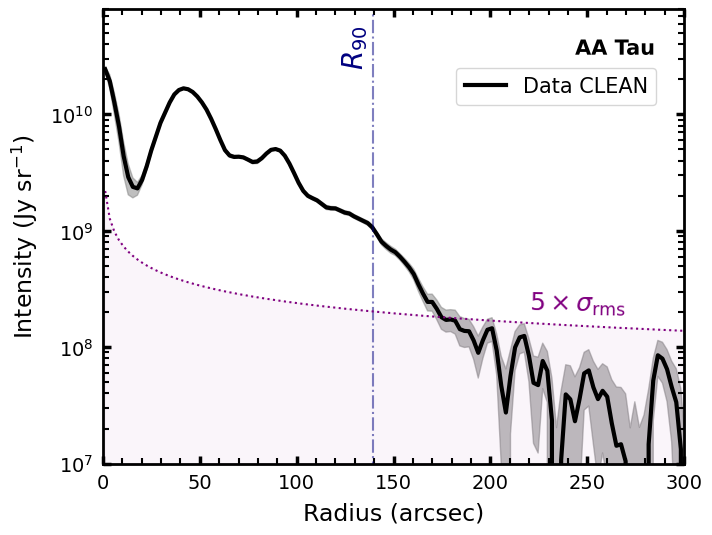

In [7]:
fig = plt.figure(figsize=(7.5, 5.9))
ax = fig.add_subplot(111)

ymin=1e7
ymax=8e10

ax.fill_between(r_clean_au, I_clean_jy_sr-dI_clean_jy_sr, I_clean_jy_sr+dI_clean_jy_sr, color='gray', alpha=0.5)
ax.plot(r_clean_au, I_clean_jy_sr, 'k', lw=3, label='Data CLEAN')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])
ax.legend(fontsize=15, bbox_to_anchor=(0.97, 0.83), loc='right')

# indicate R90
ax.vlines(R90_au, ymin/3, ymax*30, linestyle='dashdot', color='navy', lw=1.5, alpha=0.5)
ax.text(R90_au-17, ymax*0.35,'$R_{90}$', rotation=90, fontsize=20, color='navy')

# rms
bmaj = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[0]
bmin = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[1]
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2
RMS_R_data_mjy_bm = RMS_data_mjy_bm / np.sqrt((2*np.pi*r_clean_arcsec)/bmaj)
RMS_R_data_jy_sr = RMS_R_data_mjy_bm * 1e-3 / beam_area
ax.plot(r_clean_au, RMS_R_data_jy_sr*RMS_threshold, linestyle='dotted', color='purple')
ax.fill_between(r_clean_au, RMS_R_data_jy_sr*RMS_threshold, color='purple', alpha=0.04)

ax.text(220, 2e8,f'${RMS_threshold}\\times\\sigma_\\mathrm{{rms}}$', rotation=-1, fontsize=18, color='purple')

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

ax.set_yscale('log')
ax.set_ylim([ymin, ymax]) 

# Fit the exponential law

$I(R) = I_0 \, e^{-R/\lambda_{out}}$ 

In [11]:
def fit_exp(R, I0, lambdaout):
    return I0 * np.exp(-R/lambdaout)

In [13]:
# fit extended emission
mask_fit = (r_clean_au > R90_au) & (I_clean_jy_sr > RMS_R_data_jy_sr*RMS_threshold)

# No True values after the first time that True values turn to False (only if False values in between is >= 3)
first_true_idx = np.argmax(mask_fit)  # First True
first_false_after_true = first_true_idx + np.argmax(mask_fit[first_true_idx:] == False)
false_sequence_length = np.argmax(mask_fit[first_false_after_true:] == True) or len(mask_fit) - first_false_after_true
if false_sequence_length >= 3:
    mask_fit[first_false_after_true + false_sequence_length:] = False

popt, cov = scipy.optimize.curve_fit(fit_exp, r_clean_arcsec[mask_fit], I_clean_jy_sr[mask_fit], p0=[1e11, 1], sigma=dI_clean_jy_sr[mask_fit])
I0, err_I0, lambdaout, err_lambdaout = popt[0], np.sqrt(cov[0, 0]), popt[1], np.sqrt(cov[1, 1])
print(f'{target}: I0 = {I0:.2e} +/- {err_I0:.2e} Jy/sr, lambda_out = {lambdaout*distance_pc:.1f}+/-{err_lambdaout*distance_pc:.1f} au')

AA_Tau: I0 = 5.90e+11 +/- 1.86e+11 Jy/sr, lambda_out = 22.0+/-1.0 au


(10000000.0, 80000000000.0)

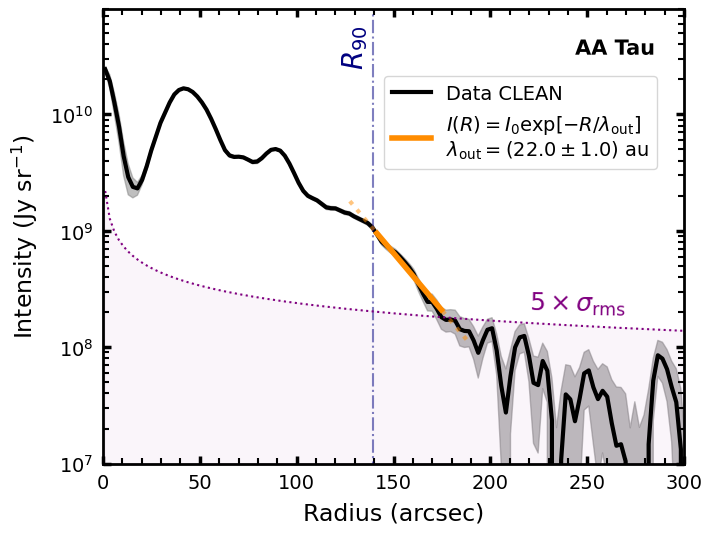

In [15]:
fig = plt.figure(figsize=(7.5, 5.9))
ax = fig.add_subplot(111)

ymin=1e7
ymax=8e10

ax.fill_between(r_clean_au, I_clean_jy_sr-dI_clean_jy_sr, I_clean_jy_sr+dI_clean_jy_sr, color='gray', alpha=0.5)
ax.plot(r_clean_au, I_clean_jy_sr, 'k', lw=3, label='Data CLEAN')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

# indicate R90
ax.vlines(R90_au, ymin/3, ymax*30, linestyle='dashdot', color='navy', lw=1.5, alpha=0.5)
ax.text(R90_au-17, ymax*0.35,'$R_{90}$', rotation=90, fontsize=20, color='navy')

# rms
bmaj = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[0]
bmin = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[1]
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2
RMS_R_data_mjy_bm = RMS_data_mjy_bm / np.sqrt((2*np.pi*r_clean_arcsec)/bmaj)
RMS_R_data_jy_sr = RMS_R_data_mjy_bm * 1e-3 / beam_area
ax.plot(r_clean_au, RMS_R_data_jy_sr*RMS_threshold, linestyle='dotted', color='purple')
ax.fill_between(r_clean_au, RMS_R_data_jy_sr*RMS_threshold, color='purple', alpha=0.04)
ax.text(220, 2e8,f'${RMS_threshold}\\times\\sigma_\\mathrm{{rms}}$', rotation=-1, fontsize=18, color='purple')

# fit of the outer disk emission
xmax = np.amax(r_clean_arcsec[mask_fit])*1.6
r_dotted = np.linspace(np.amin(r_clean_arcsec[mask_fit])-np.amax(xmax)*0.05, np.amax(r_clean_arcsec[mask_fit])+np.amax(xmax)*0.05, 200)
ax.plot(r_dotted*distance_pc, fit_exp(r_dotted,*popt), color='darkorange', zorder=10, lw=3,linestyle='dotted', alpha=0.5)
ax.plot(r_clean_arcsec[mask_fit]*distance_pc, fit_exp(r_clean_arcsec[mask_fit],*popt), color='darkorange', zorder=10, lw=4, label=f'$I(R) = I_0 \\exp[-R/\\lambda_\\mathrm{{out}}]$\n$\\lambda_\\mathrm{{out}}=({(lambdaout*distance_pc):.1f}\\pm{(err_lambdaout*distance_pc):.1f})$ au')

ax.legend(fontsize=14, bbox_to_anchor=(0.97, 0.75), loc='right')

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

ax.set_yscale('log')
ax.set_ylim([ymin, ymax]) 

# Fit a Gaussian to get the resolution of the outer disk falloff

In [18]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

def fit_gaussian(x, A, sigma):
    mu = R90_arcsec
    return gaussian(x, A, mu, sigma)

In [20]:
mask_fit = (r_clean_au > R90_au) & (I_clean_jy_sr > RMS_R_data_jy_sr*RMS_threshold)

# No True values after the first time that True values turn to False (only if False values in between is >= 3)
first_true_idx = np.argmax(mask_fit)  # First True
first_false_after_true = first_true_idx + np.argmax(mask_fit[first_true_idx:] == False)
false_sequence_length = np.argmax(mask_fit[first_false_after_true:] == True) or len(mask_fit) - first_false_after_true
if false_sequence_length >= 3:
    mask_fit[first_false_after_true + false_sequence_length:] = False


popt, pcov = scipy.optimize.curve_fit(lambda x, A, sigma: fit_gaussian(x, A, sigma), r_clean_arcsec[mask_fit], I_clean_jy_sr[mask_fit], p0=[1e11, 1], sigma=dI_clean_jy_sr[mask_fit])
A_fit, err_A_fit, sigma_fit, err_sigma_fit = popt[0], np.sqrt(pcov[0, 0]), popt[1], np.sqrt(pcov[1, 1])
print(f'A fit = {np.abs(A_fit):.2e}\\pm{np.abs(err_A_fit):.2e}')
print(f'sigma of Gaussian fit = {np.abs(sigma_fit)*distance_pc:.2f}\\pm{np.abs(err_sigma_fit)*distance_pc:.2f}')
sigma_beam = (((bmaj+bmin)/2) / (2*np.sqrt(2*np.log(2))))
print(f'sigma synthesized beam = {sigma_beam*distance_pc:.2f}')
print(f'Resolution sigma_fit/sigma_beam = {sigma_fit/sigma_beam:.2f}')

A fit = 8.17e+08\pm2.14e+07
sigma of Gaussian fit = 18.59\pm0.55
sigma synthesized beam = 3.66
Resolution sigma_fit/sigma_beam = 5.08


(10000000.0, 80000000000.0)

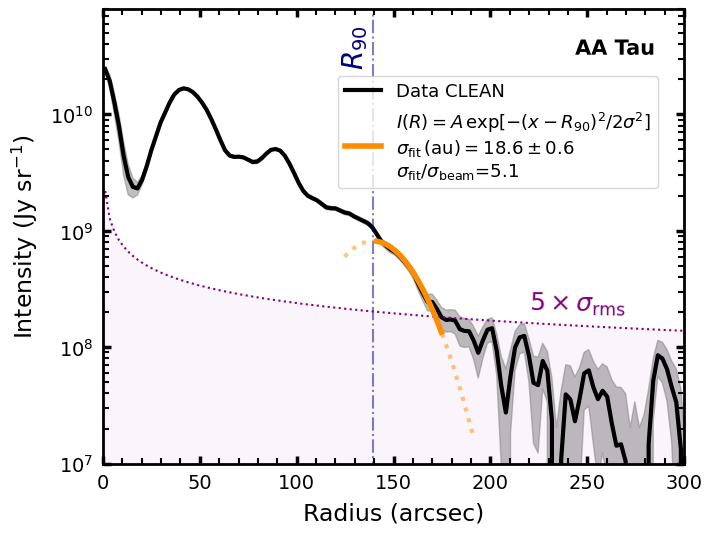

In [22]:
fig = plt.figure(figsize=(7.5, 5.9))
ax = fig.add_subplot(111)

ax.fill_between(r_clean_au, I_clean_jy_sr-dI_clean_jy_sr, I_clean_jy_sr+dI_clean_jy_sr, color='gray', alpha=0.5)
ax.plot(r_clean_au, I_clean_jy_sr, 'k', lw=3, label='Data CLEAN')

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

# indicate R90
ax.vlines(R90_au, ymin/3, ymax*30, linestyle='dashdot', color='navy', lw=1.5, alpha=0.5)
ax.text(R90_au-17, ymax*0.35,'$R_{90}$', rotation=90, fontsize=20, color='navy')

# rms
bmaj = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[0]
bmin = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[1]
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2
RMS_R_data_mjy_bm = RMS_data_mjy_bm / np.sqrt((2*np.pi*r_clean_arcsec)/bmaj)
RMS_R_data_jy_sr = RMS_R_data_mjy_bm * 1e-3 / beam_area
ax.plot(r_clean_au, RMS_R_data_jy_sr*RMS_threshold, linestyle='dotted', color='purple')
ax.fill_between(r_clean_au, RMS_R_data_jy_sr*RMS_threshold, color='purple', alpha=0.04)
ax.text(220, 2e8,f'${RMS_threshold}\\times\\sigma_\\mathrm{{rms}}$', rotation=-1, fontsize=18, color='purple')

# fit of the outer disk emission
xmax = np.amax(r_clean_arcsec)
r_dotted = np.linspace(np.amin(r_clean_arcsec[mask_fit])-np.amax(xmax)*0.05, np.amax(r_clean_arcsec[mask_fit])+np.amax(xmax)*0.05, 200)
ax.plot(r_dotted*distance_pc, fit_gaussian(r_dotted,*popt), color='darkorange', zorder=10, lw=3,linestyle='dotted', alpha=0.5)

label_gaussfit =f'$I(R) = A\\, \\exp[- (x-R_{{90}})^2/2\\sigma^2]$\n$\\sigma_\\mathrm{{fit}}\\,\\mathrm{{(au)}}={sigma_fit*distance_pc:.1f}\\pm{err_sigma_fit*distance_pc:.1f}$\n$\\sigma_\\mathrm{{fit}}/\\sigma_\\mathrm{{beam}}$={sigma_fit/sigma_beam:.1f}'
ax.plot(r_clean_arcsec[mask_fit]*distance_pc, fit_gaussian(r_clean_arcsec[mask_fit],*popt), color='darkorange', zorder=10, lw=4, 
       label=label_gaussfit)

ax.legend(fontsize=13, bbox_to_anchor=(0.97, 0.73), loc='right')

ax.set_xlim([0, lim])
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=7,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=7,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('Radius (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Intensity (Jy sr$^{-1}$)', fontsize = 17, labelpad=7)

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(2) 

ax.set_yscale('log')
ax.set_ylim([ymin, ymax]) 

In [24]:
print(f'Final result \nlambda_out = {lambdaout*distance_pc:.1f}+/-{err_lambdaout*distance_pc:.1f} au\nResolution sigma_Gaussfit/sigma_beam = {sigma_fit/sigma_beam:.1f}')

Final result 
lambda_out = 22.0+/-1.0 au
Resolution sigma_Gaussfit/sigma_beam = 5.1
